In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import datasets
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## SGLD optimizer

In [4]:
class SGLD(optim.SGD):
    def __init__(self, params, lr=1e-3):
        super(SGLD, self).__init__(params, lr=lr)
        

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                noise = torch.randn_like(p) * torch.sqrt(torch.tensor(group['lr'] * 2 ))
                p.data.add_(-group['lr'], d_p + noise)

        return loss

## Irr optimizer


In [5]:
def create_antisymmetric_matrix(dim):
    matrix = np.array([[0] * dim for _ in range(dim)])
    for i in range(dim):
        for j in range(i + 1, dim):
            matrix[i][j] =  1
            matrix[j][i] = -matrix[i][j]
    return matrix

matrix_np = create_antisymmetric_matrix(10)
A = torch.from_numpy(matrix_np)
I= torch.eye(10)  


In [6]:
class IrrOptim(optim.SGD):
    def __init__(self, params, lr=1e-3, temperature=1.0):
        super(IrrOptim, self).__init__(params, lr=lr)
        self.temperature = temperature


    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                noise = torch.randn_like(p) * torch.sqrt(torch.tensor(group['lr'] * 0.2))

  
                #A即为反对称矩阵
                d_p = torch.matmul(torch.add(I, self.temperature*A).to(device), d_p)
            
                p.data.add_(-group['lr'], d_p + noise)

        return loss

In [56]:
class ExchangeIrrOptim(optim.SGD):
    def __init__(self, params, lr=1e-3):
        super(ExchangeIrrOptim, self).__init__(params, lr=lr)
    

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if d_p.is_sparse:
                    raise RuntimeError('SGLD does not support sparse gradients')
                
                #noise = torch.randn_like(p) * torch.sqrt(torch.tensor(group['lr'] * 0.2 ))
                
                if loss is not None:
                    if loss < 0.2:
                        d_p = torch.matmul(torch.add(I, 0.1*A).to(device), d_p)
            
                    else:
                         d_p = torch.matmul(torch.add(I, 1.0*A).to(device), d_p)
            
                p.data.add_(-group['lr'], d_p +noise)

        return loss

## Experiment on Mnist

In [9]:
STEP=5
GAMMA=0.5
BATCH_SIZE=128
Trans = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(mean = (0.1307,),std = (0.3081,))
                               ])

train_set = datasets.MNIST("data",train=True,download=True,transform=Trans)
test_set = datasets.MNIST("data",train=False,download=True,transform=Trans)
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

In [10]:
def Output(model, image, target): 
    criterion = nn.CrossEntropyLoss()
    output = model(image)
    loss=criterion(output,target)
    return output, loss

In [50]:
def test(model,optimizer,scheduler,EPOCHS):
    Train_loss=[]
    Train_accuracy=[]
    for epoch in range(EPOCHS):
        running_cls_loss = 0.0
        running_cls_corrects = 0
        for batch_idx, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = Output(model, image, target)
            _, preds = torch.max(outputs, 1) 
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            loss.backward()
            optimizer.step(lambda: loss.item())
            optimizer.zero_grad()
        
        scheduler.step()
        epoch_loss = running_cls_loss*BATCH_SIZE / len(train_set)
        Train_loss.append(epoch_loss)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        print("Train Accuracy when epoch=",epoch,":",format(epoch_acc*100, '.2f'),"%")
        Train_accuracy.append(epoch_acc.cpu())

        
        if  (epoch +1) == EPOCHS:
            model.eval()
            val_loss = 0.0
            val_corrects = 0
            for batch_idx, (image, target) in enumerate(test_loader):
                image = image.to(device)
                target = target.to(device)
                outputs, loss = Output(model, image, target)
                _, preds = torch.max(outputs, 1)  
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)    
            
            val_acc = val_corrects.double() / len(test_set)
            return Train_loss,Train_accuracy,val_acc

In [12]:
model1 = Net()
model1.to(device)
sgld=SGLD(model1.parameters(), lr=0.01)
sgldscheduler = torch.optim.lr_scheduler.StepLR(sgld, step_size=STEP, gamma=GAMMA)
resgld=test(model1,sgld,sgldscheduler,20)
Sgld_Train_Loss=resgld[0]
Sgld_Train_Accuracy=resgld[1]
print("Accuracy for SGLD in Mnist:",format(resgld[2]*100, '.2f'),"%")

/tmp/ipykernel_1576/2574970634.py:18: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1533.)
  p.data.add_(-group['lr'], d_p + noise)


Train Accuracy when epoch= 0 : 31.19 %
Train Accuracy when epoch= 1 : 64.22 %
Train Accuracy when epoch= 2 : 79.03 %
Train Accuracy when epoch= 3 : 84.48 %
Train Accuracy when epoch= 4 : 86.61 %
Train Accuracy when epoch= 5 : 87.73 %
Train Accuracy when epoch= 6 : 88.47 %
Train Accuracy when epoch= 7 : 88.92 %
Train Accuracy when epoch= 8 : 89.30 %
Train Accuracy when epoch= 9 : 89.68 %
Train Accuracy when epoch= 10 : 89.90 %
Train Accuracy when epoch= 11 : 90.07 %
Train Accuracy when epoch= 12 : 90.18 %
Train Accuracy when epoch= 13 : 90.31 %
Train Accuracy when epoch= 14 : 90.34 %
Train Accuracy when epoch= 15 : 90.55 %
Train Accuracy when epoch= 16 : 90.56 %
Train Accuracy when epoch= 17 : 90.62 %
Train Accuracy when epoch= 18 : 90.70 %
Train Accuracy when epoch= 19 : 90.73 %
Accuracy for SGLD in Mnist: 90.51 %


In [13]:
result={}
for i in range(1, 11):
    model = Net()
    model.to(device)
    irr=IrrOptim(model.parameters(), lr=0.01, temperature=i*0.1)
    irrscheduler = torch.optim.lr_scheduler.StepLR(irr, step_size=STEP, gamma=GAMMA)
    reIrr=test(model,irr,irrscheduler,20)
    result[i]=reIrr
    print("Accuracy for Irr in Mnist when temperature=",i*0.1,":",format(reIrr[2]*100, '.2f'),"%")

Train Accuracy when epoch= 0 : 53.91 %
Train Accuracy when epoch= 1 : 84.20 %
Train Accuracy when epoch= 2 : 87.74 %
Train Accuracy when epoch= 3 : 89.32 %
Train Accuracy when epoch= 4 : 90.17 %
Train Accuracy when epoch= 5 : 90.73 %
Train Accuracy when epoch= 6 : 90.98 %
Train Accuracy when epoch= 7 : 91.20 %
Train Accuracy when epoch= 8 : 91.40 %
Train Accuracy when epoch= 9 : 91.63 %
Train Accuracy when epoch= 10 : 91.79 %
Train Accuracy when epoch= 11 : 91.87 %
Train Accuracy when epoch= 12 : 91.94 %
Train Accuracy when epoch= 13 : 92.03 %
Train Accuracy when epoch= 14 : 92.07 %
Train Accuracy when epoch= 15 : 92.15 %
Train Accuracy when epoch= 16 : 92.20 %
Train Accuracy when epoch= 17 : 92.26 %
Train Accuracy when epoch= 18 : 92.22 %
Train Accuracy when epoch= 19 : 92.28 %
Accuracy for Irr in Mnist when temperature= 0.1 : 91.99 %
Train Accuracy when epoch= 0 : 47.17 %
Train Accuracy when epoch= 1 : 81.53 %
Train Accuracy when epoch= 2 : 86.46 %
Train Accuracy when epoch= 3 : 88.6

<Figure size 800x600 with 0 Axes>

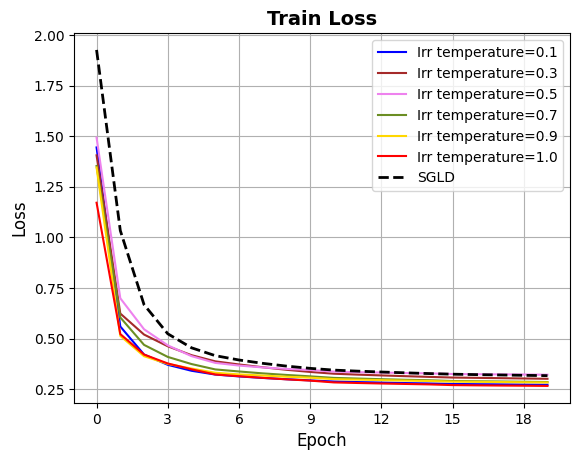

In [39]:
plt.figure(figsize=(8, 6))  
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.plot(result.get(1)[0],label=f"Irr temperature={0.1}", linestyle='-', linewidth=1.5, color='blue')
#plt.plot(result.get(2)[0],label=f"Irr temperature={0.2}", linestyle='-', linewidth=1.5, color='purple')
plt.plot(result.get(3)[0],label=f"Irr temperature={0.3}", linestyle='-', linewidth=1.5, color='brown')
#plt.plot(result.get(4)[0],label=f"Irr temperature={0.4}", linestyle='-', linewidth=1.5, color='orange')
plt.plot(result.get(5)[0],label=f"Irr temperature={0.5}", linestyle='-', linewidth=1.5, color='violet')
#plt.plot(result.get(6)[0],label=f"Irr temperature={0.6}", linestyle='-', linewidth=1.5, color='powderblue')
plt.plot(result.get(7)[0],label=f"Irr temperature={0.7}", linestyle='-', linewidth=1.5, color='olivedrab')
#plt.plot(result.get(8)[0],label=f"Irr temperature={0.8}", linestyle='-', linewidth=1.5, color='grey')
plt.plot(result.get(9)[0],label=f"Irr temperature={0.9}", linestyle='-', linewidth=1.5, color='gold')
plt.plot(result.get(10)[0],label=f"Irr temperature={1.0}", linestyle='-', linewidth=1.5, color='red')
plt.plot(Sgld_Train_Loss, label="SGLD", linestyle='--', linewidth=2.0, color='black')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Loss', fontsize=12) 
plt.title('Train Loss', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()

<Figure size 800x600 with 0 Axes>

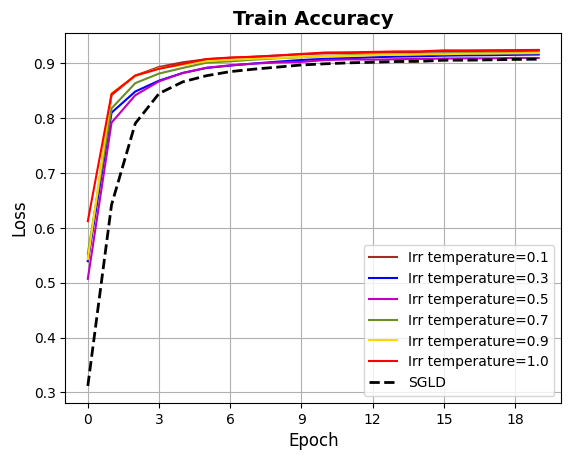

In [44]:
plt.figure(figsize=(8, 6))  
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.plot(result.get(1)[1],label=f"Irr temperature={0.1}", linestyle='-', linewidth=1.5, color='brown')
#plt.plot(result.get(2)[1],label=f"Irr temperature={0.2}", linestyle='-', linewidth=1.5, color='purple')
plt.plot(result.get(3)[1],label=f"Irr temperature={0.3}", linestyle='-', linewidth=1.5, color='blue')
#plt.plot(result.get(4)[1],label=f"Irr temperature={0.4}", linestyle='-', linewidth=1.5, color='orange')
plt.plot(result.get(5)[1],label=f"Irr temperature={0.5}", linestyle='-', linewidth=1.5, color='m')
#plt.plot(result.get(6)[1],label=f"Irr temperature={0.6}", linestyle='-', linewidth=1.5, color='powderblue')
plt.plot(result.get(7)[1],label=f"Irr temperature={0.7}", linestyle='-', linewidth=1.5, color='olivedrab')
#plt.plot(result.get(8)[1],label=f"Irr temperature={0.8}", linestyle='-', linewidth=1.5, color='grey')
plt.plot(result.get(9)[1],label=f"Irr temperature={0.9}", linestyle='-', linewidth=1.5, color='gold')
plt.plot(result.get(10)[1],label=f"Irr temperature={1.0}", linestyle='-', linewidth=1.5, color='red')
plt.plot(Sgld_Train_Accuracy, label="SGLD", linestyle='--', linewidth=2, color='black')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Accuracy', fontsize=12) 
plt.title('Train Accuracy', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()



In [66]:
result={}
for i in range(1, 9):
    model = Net()
    model.to(device)
    irr=IrrOptim(model.parameters(), lr=0.01, temperature=i*0.5)
    irrscheduler = torch.optim.lr_scheduler.StepLR(irr, step_size=STEP, gamma=GAMMA)
    reIrr=test(model,irr,irrscheduler,20)
    result[i]=reIrr
    print("Accuracy for Irr in Mnist when temperature=",i*0.5,":",format(reIrr[2]*100, '.2f'),"%")

Train Accuracy when epoch= 0 : 41.01 %
Train Accuracy when epoch= 1 : 80.87 %
Train Accuracy when epoch= 2 : 86.98 %
Train Accuracy when epoch= 3 : 88.70 %
Train Accuracy when epoch= 4 : 89.66 %
Train Accuracy when epoch= 5 : 90.37 %
Train Accuracy when epoch= 6 : 90.55 %
Train Accuracy when epoch= 7 : 90.79 %
Train Accuracy when epoch= 8 : 91.06 %
Train Accuracy when epoch= 9 : 91.20 %
Train Accuracy when epoch= 10 : 91.37 %
Train Accuracy when epoch= 11 : 91.47 %
Train Accuracy when epoch= 12 : 91.53 %
Train Accuracy when epoch= 13 : 91.65 %
Train Accuracy when epoch= 14 : 91.67 %
Train Accuracy when epoch= 15 : 91.82 %
Train Accuracy when epoch= 16 : 91.83 %
Train Accuracy when epoch= 17 : 91.86 %
Train Accuracy when epoch= 18 : 91.89 %
Train Accuracy when epoch= 19 : 91.94 %
Accuracy for Irr in Mnist when temperature= 0.5 : 91.58 %
Train Accuracy when epoch= 0 : 52.67 %
Train Accuracy when epoch= 1 : 80.53 %
Train Accuracy when epoch= 2 : 86.48 %
Train Accuracy when epoch= 3 : 88.1

<Figure size 800x600 with 0 Axes>

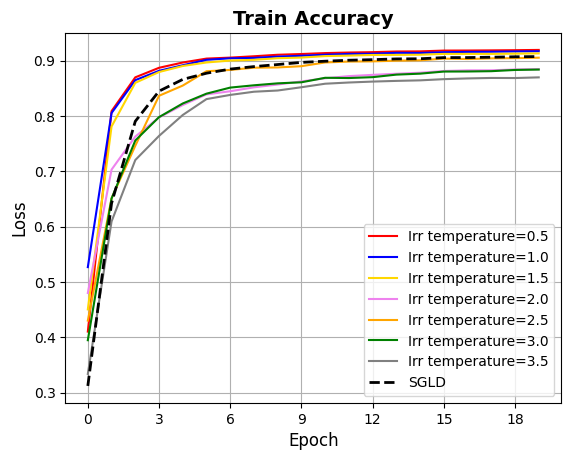

In [78]:
plt.figure(figsize=(8, 6))  
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.plot(result.get(1)[1],label=f"Irr temperature={0.5}", linestyle='-', linewidth=1.5, color='red')
plt.plot(result.get(2)[1],label=f"Irr temperature={1.0}", linestyle='-', linewidth=1.5, color='blue')
plt.plot(result.get(3)[1],label=f"Irr temperature={1.5}", linestyle='-', linewidth=1.5, color='gold')
plt.plot(result.get(4)[1],label=f"Irr temperature={2.0}", linestyle='-', linewidth=1.5, color='violet')
plt.plot(result.get(5)[1],label=f"Irr temperature={2.5}", linestyle='-', linewidth=1.5, color='orange')
plt.plot(result.get(6)[1],label=f"Irr temperature={3.0}", linestyle='-', linewidth=1.5, color='green')
plt.plot(result.get(7)[1],label=f"Irr temperature={3.5}", linestyle='-', linewidth=1.5, color='grey')
plt.plot(Sgld_Train_Accuracy, label="SGLD", linestyle='--', linewidth=2, color='black')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Loss', fontsize=12) 
plt.title('Train Accuracy', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()


<Figure size 800x600 with 0 Axes>

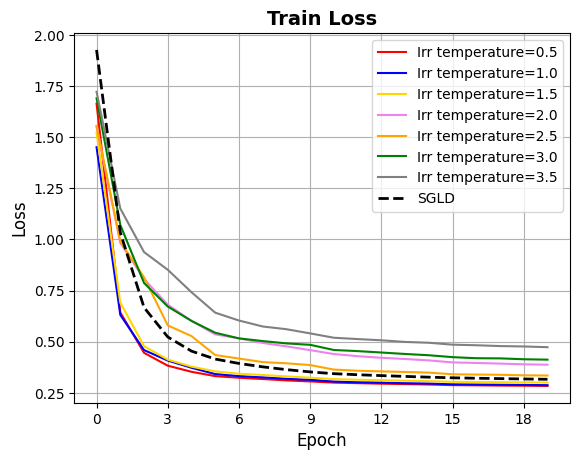

In [79]:
plt.figure(figsize=(8, 6))  
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.plot(result.get(1)[0],label=f"Irr temperature={0.5}", linestyle='-', linewidth=1.5, color='red')
plt.plot(result.get(2)[0],label=f"Irr temperature={1.0}", linestyle='-', linewidth=1.5, color='blue')
plt.plot(result.get(3)[0],label=f"Irr temperature={1.5}", linestyle='-', linewidth=1.5, color='gold')
plt.plot(result.get(4)[0],label=f"Irr temperature={2.0}", linestyle='-', linewidth=1.5, color='violet')
plt.plot(result.get(5)[0],label=f"Irr temperature={2.5}", linestyle='-', linewidth=1.5, color='orange')
plt.plot(result.get(6)[0],label=f"Irr temperature={3.0}", linestyle='-', linewidth=1.5, color='green')
plt.plot(result.get(7)[0],label=f"Irr temperature={3.5}", linestyle='-', linewidth=1.5, color='grey')
plt.plot(Sgld_Train_Loss, label="SGLD", linestyle='--', linewidth=2, color='black')
plt.xlabel('Epoch', fontsize=12)  
plt.ylabel('Accuracy', fontsize=12) 
plt.title('Train Loss', fontsize=14, fontweight='bold') 
plt.grid(True)
plt.legend(fontsize=10) 
plt.show()

In [46]:
model2 = Net()
model2.to(device)
exirr=ExchangeIrrOptim(model2.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(exirr, step_size=STEP, gamma=GAMMA)
re=test(model2,exirr,scheduler)
Train_Loss=re[0]
Train_Accuracy=re[1]
print("Accuracy for Exchange Irr in Mnist:",format(re[2]*100, '.2f'),"%")

Train Accuracy when epoch= 0 : 47.39 %
Train Accuracy when epoch= 1 : 82.31 %
Train Accuracy when epoch= 2 : 86.40 %
Train Accuracy when epoch= 3 : 88.45 %
Train Accuracy when epoch= 4 : 89.39 %
Train Accuracy when epoch= 5 : 90.57 %
Train Accuracy when epoch= 6 : 90.82 %
Train Accuracy when epoch= 7 : 91.08 %
Train Accuracy when epoch= 8 : 91.26 %
Train Accuracy when epoch= 9 : 91.58 %
Train Accuracy when epoch= 10 : 91.77 %
Train Accuracy when epoch= 11 : 91.90 %
Train Accuracy when epoch= 12 : 91.94 %
Train Accuracy when epoch= 13 : 91.96 %
Train Accuracy when epoch= 14 : 92.10 %
Train Accuracy when epoch= 15 : 92.20 %
Train Accuracy when epoch= 16 : 92.22 %
Train Accuracy when epoch= 17 : 92.22 %
Train Accuracy when epoch= 18 : 92.29 %
Train Accuracy when epoch= 19 : 92.34 %
Accuracy for Exchange Irr in Mnist: 92.14 %
